In [1]:
import os, importlib
import pandas as pd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

import _pickle as cPickle
import torch
from torch.utils.data import DataLoader

from dataset import CustomTest

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

### Save dataset list to txt

In [4]:
data_paths = []
chex_root = "CheXpert"

for root, dirs, files in os.walk(chex_root):
    for file in files:
        if file.endswith(".png") or file.endswith(".jpg"):
            data_paths.append(os.path.join(root, file))
            
with open("data/chexpert.txt", "w") as f:
    for path in data_paths:
        f.write(path + "\n")

#### Configuration

In [5]:
base = "configs/cxr_f8_vqgan.yaml"
config = OmegaConf.load(base)

#### Load VQGAN Model

In [6]:
model = instantiate_from_config(config.model)

Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
Restored from vqgan_f8.ckpt


### Save latent and label to pickle

In [8]:
cls_dict = {"Enlarged Cardiomediastinum": 0, "Cardiomegaly": 1, "Lung Opacity": 2, "Lung Lesion": 3,
 "Edema": 4, "Consolidation": 5, "Pneumonia": 6, "Atelectasis": 7, "Pneumothorax": 8, 
 "Pleural Effusion":9 , "Pleural Other": 10, "Fracture": 11, "Support Devices": 12, "No Finding": 13}

In [23]:
data_list = f"data/chexpert.txt"
dataset = CustomTest(size=256, test_images_list_file=data_list)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8)

chex_train = pd.read_csv('CheXpert/train_visualCheXbert.csv')

chex_train['Path'] = chex_train['Path'].apply(lambda x: x.split('CheXpert-v1.0/')[-1])

vq_list = {}
fs = 8
dataname = "chexpert"
filename = f'{dataname}_{fs}.pkl'

model = model.cuda()
with open(filename, 'wb') as f:
    for data in data_loader:
        file_path_ = data['file_path_'][0].split(' ')[0]
        image_index = file_path_.split('chexpert/')[-1]
        
        if "frontal" not in image_index: continue
        if image_index not in chex_train['Path'].values: continue

        label = []
        for key in cls_dict.keys():
            if chex_train[chex_train['Path'] == image_index][key].values[0] == 1:
                label.append(cls_dict[key])

        image = data['image']
        image = image.permute(0, 3, 1, 2).cuda()
        latent = model.encoder(image).cpu().detach().numpy().squeeze()

        vq_list[image_index] = {'latent': latent, 'label': label}
        break

    print("save latent to", filename)
    cPickle.dump(vq_list, f)

save latent to chexpert_8.pkl


### Reconstruction

In [33]:
model = model.cpu()

h = torch.tensor(latent).unsqueeze(0)
h = model.quant_conv(h)
quant, _, _ = model.quantize(h)
quant = model.post_quant_conv(quant)
recon = model.decoder(quant)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2184873..1.3959346].


Text(0.5, 1.0, 'recon')

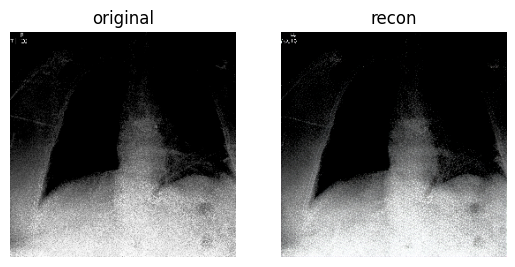

In [42]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(image[0].permute(1, 2, 0).detach().cpu().numpy())
ax[1].imshow(recon[0].permute(1, 2, 0).detach().cpu().numpy())

ax[0].axis("off")
ax[1].axis("off")

ax[0].set_title("original")
ax[1].set_title("recon")